### Notebook to be used to test that ATCamera, ATHeaderService and ATArchiver are online and working

In [1]:
import numpy as np
from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter
from matplotlib import pyplot as plt
from astropy import time as astropytime
#%matplotlib ipympl
plt.rcParams['figure.figsize'] = [7, 6]

import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.afw.display as afwDisplay

afwDisplay.setDefaultBackend('matplotlib')
import time
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.geom

import os
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')

In [2]:
# Want to display in firefly?
afwDisplay.setDefaultBackend('firefly')
os.environ['FIREFLY_HTML'] = "slate.html"
os.environ['FIREFLY_URL'] = 'http://139.229.170.210:8080/firefly/'

In [3]:
# # Setup the butler
#accs_images = True
accs_images = False
if accs_images:
    repo = os.path.join("/home/saluser/ingest/accs/")#, mapper={'calibRoot': "/home/saluser/ingest/dmcs/CALIB"})
    butler = dafPersist.Butler(repo)
else:
    #repo = os.path.join("/home/saluser/ingest/dmcs/")#, mapper={'calibRoot': "/home/saluser/ingest/dmcs/CALIB"})
    repo = os.path.join("/mnt/dmcs/oods_butler_repo/repo/")
    butler = dafPersist.Butler(repo) #
    #butler = dafPersist.Butler(repo, mapper="lsst.obs.lsst.auxTel.AuxTelMapper")
#test   
#raw = butler.get("raw", visit=2019111300004)
#image = raw.getImage().array

In [4]:
# Load the LATISS class
from lsst.ts.standardscripts.auxtel.latiss import LATISS

latiss = LATISS()
#latiss = LATISS(salobj.Remote(domain=d, name="ATCamera"), 
#                salobj.Remote(domain=d, name="ATSpectrograph"))

await latiss.start_task 

2020-01-31 17:31:54,322 ATArchiver   INFO     Read historical data in 8.64 sec
2020-01-31 17:31:54,716 ATHeaderService INFO     Read historical data in 9.04 sec
2020-01-31 17:31:55,041 ATSpectrograph INFO     Read historical data in 9.36 sec
2020-01-31 17:31:55,639 ATCamera     INFO     Read historical data in 9.96 sec


[None, None, None, None]

## Perform State Transitions

In [12]:
# Get state of CSC
salobj.State((atcs.athexapod.evt_summaryState.get()).summaryState)

NameError: name 'atcs' is not defined

In [5]:
# State transitions
#await salobj.set_summary_state(latiss.atspec, salobj.State.OFFLINE, timeout=60, settingsToApply='current')

In [6]:
#Setup LATISS
#await latiss.atspec.cmd_homeLinearStage.start(timeout=90)
await latiss.setup_atspec(filter='blank_bk7_wg05', grating='ronchi170lpmm')#, linear_stage=60)

## Take an exposure

In [ ]:
#First flush events that we want to listen to

expTime=60
group_id=astropytime.Time.now().tai.isot
#tmp = await latiss.take_bias(nbias=10)#, exptime=5)
#tmp = await latiss.take_darks(exptime=300, ndarks=1)#, exptime=5)

file_obj = await latiss.take_image(exptime=expTime, shutter=True,image_type='OBJECT',group_id=group_id, filter='KPNO_406_828nm', grating='empty_1') # 'blank_bk7_wg05' KPNO_406_828nm'  'KPNO_1111_436nm' 'KPNO_373A_677nm' 'ronchi170lpmm'

#file_obj = await latiss.take_image(exptime=expTime, shutter=True,image_type='ENGTEST',group_id='HD28464')

In [9]:
file_obj.imageName

NameError: name 'file_obj' is not defined

In [ ]:
# parse out visitID from filename - this is highly annoying
tmp=file_obj.imageName.split('_')
prefix=tmp[2] # dayobs without the dashes

# Don't remember why I used int here... whitespace? 
# surely fixable but bigger fish.
suffix='{:05d}'.format(int(tmp[3].split('-')[0])) # SEQNUM, but need to trim extra 0 in obsid
visitID = int((prefix+suffix))

In [ ]:
## Load file from Butler
import importlib
import utils.processExposure 
importlib.reload(utils.processExposure)
from utils.processExposure import processExposure

In [5]:
visitID = 2020012800379 #292
print(visitID)


2020012800379


In [6]:
from lsst.rapid.analysis.bestEffort import BestEffortIsr
REPODIR = '/mnt/dmcs/oods_butler_repo/repo'
bestEffort = BestEffortIsr(REPODIR)
isr_corr_exposure = bestEffort.getExposure(visitID)

2020-01-31 17:31:57,631 lsst.obs.lsst.translators.latiss WARNING  AT_O_20200128_000379: Dark time less than exposure time. Setting dark time to the exposure time.


Caught 'LatissMapper' object has no attribute 'map_linearizer' - update your mapper?
Running with bias subtraction
Running with dark correction subtraction
Running cosmic ray repair


In [7]:
# # Grab image from butler, but have to redefine butler after each image
# butler = dafPersist.Butler(repo)
# exposure = butler.get("raw", visit=visitID)
# #image = raw.getImage().array

# # do ISR correction
# isr_corr_exposure = processExposure(exposure, repo=repo, bias=None, flat=False, defects=False )
# #isr_corr_exposure = exposure

2020-01-31 17:32:08,037 ATSpectrograph WARNING  RemoteEvent(ATSpectrograph, 0, heartbeat) falling behind; read 13 messages
2020-01-31 17:32:08,051 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, heartbeat) falling behind; read 12 messages
2020-01-31 17:32:08,063 ATArchiver   WARNING  RemoteEvent(ATArchiver, 0, heartbeat) falling behind; read 12 messages


In [8]:
plt.close('all')
disp = afwDisplay.Display(2, reopenPlot=True, verbose=True)

Opening firefly device 2
Starting vanilla client
Firefly URL is http://139.229.170.210:8080/firefly/slate.html?__wsch=c2FsdXNlcjIwMjAtMDEtMzE


virtual[2]._setImageColormap(cmap="gray")


In [10]:
if True: # display the image in firefly
    #plt.close('all')
    #disp = afwDisplay.Display(2, reopenPlot=True)
    disp.setMaskPlaneColor('SAT', afwDisplay.IGNORE)
    disp.setImageColormap('gray')
    disp.scale('linear', 'zscale')
    disp.mtv(isr_corr_exposure, title='visit = {}'.format(visitID))
    #cgUtils.overlayCcdBoxes(isr_corr_exposure.getDetector(), isTrimmed=True, display=disp)

virtual[2]._setImageColormap(cmap="gray")
displaying image
region layer id is lsstRegions2
displaying mask


In [96]:
# Only here for me to debug, should be up top with other declarations
import importlib
import utils.findNarrowbandRonchiPeaks
importlib.reload(utils.findNarrowbandRonchiPeaks)
from utils.findNarrowbandRonchiPeaks import findNarrowbandRonchiPeaks

import utils.fitExposure
importlib.reload(utils.fitExposure)
from utils.fitExposure import fit2DGaussian

import utils.calc_CofM
importlib.reload(utils.calc_CofM)
from utils.calc_CofM import calc_CofM

import utils.calc_encircled_energy
importlib.reload(utils.calc_encircled_energy)
from utils.calc_encircled_energy import calc_encircled_energy

import utils.findBrightestSourceInBox
importlib.reload(utils.findBrightestSourceInBox)
from utils.findBrightestSourceInBox import findBrightestSourceInBox

In [97]:
# Source detection libraries
from lsst.meas.algorithms.detection import SourceDetectionTask
import lsst.afw.table as afwTable

# create the output table for source detection
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10  # detection threshold after smoothing
sourceDetectionTask = SourceDetectionTask(schema=schema, config=config)
tab = afwTable.SourceTable.make(schema)
result = sourceDetectionTask.run(tab, isr_corr_exposure, sigma=8.1)

In [98]:
#help(isr_corr_exposure)

## Fit a gaussian

<Gaussian2D(amplitude=17312.48483393, x_mean=3181.19219286, y_mean=2221.53105554, x_stddev=7.4500382, y_stddev=6.8159026, theta=0.)>
Visit ID = 2020012800335
Closing firefly device 2
Closing firefly device 2


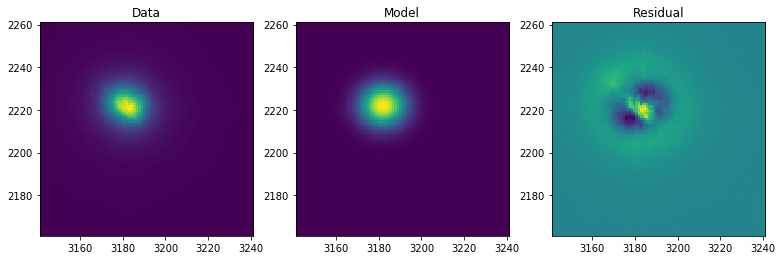

2020-01-29 06:11:34,341 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 10 messages
2020-01-29 06:11:50,888 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 10 messages
2020-01-29 06:33:35,314 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 16 messages
2020-01-29 06:46:41,622 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 10 messages
2020-01-29 07:11:08,248 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, logMessage) falling behind; read 11 messages
2020-01-29 15:05:24,964 ATHeaderService WARNING  RemoteEvent(ATHeaderService, 0, heartbeat) falling behind; read 10 messages


In [105]:
# Find 0th and +/- 1 order peaks 
sources = result.sources
zeroth_order_estimate = lsst.geom.Point2D(2320,2350)
zeroth_order_estimate = lsst.geom.Point2D(3190,2210)
zeroth_order_star_BBox= lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(400,400)) 
bbox0 = lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(100,100)) 
wavelength= 677.0 
dispersion =  0 #(1/0.6358) # pixels/nm
spectral_position_angle= 0.0107 # radians clockwise from top
#center_source, peak1, peak2 = findNarrowbandRonchiPeaks(sources, zeroth_order_star_BBox, wavelength, dispersion, spectral_position_angle)

center_source, center_peak = findBrightestSourceInBox(sources, zeroth_order_star_BBox)

peak0_subim = isr_corr_exposure.subset(bbox0)
p0, x0 , y0 = fit2DGaussian(peak0_subim, plot=True)
print('Visit ID = {}'.format(visitID))

In [31]:
# peak0_subim = isr_corr_exposure.subset(bbox0)
# p0, x0 , y0 = fit2DGaussian(peak0_subim, plot=True)

In [87]:

# # Fit peaks
# # zeroth order
# # variables names are weird here because I can't think of a clever way to have -1 and +1 as variable names

# #bbox0 = lsst.geom.Box2I.makeCenteredBox(center_source.getFootprint().getCentroid(), lsst.geom.Extent2I(100,100)) 

# print('visitID is: {}'.format(visitID))
# zeroth_order_estimate = lsst.geom.Point2D(1630,1330)
# #zeroth_order_estimate = lsst.geom.Point2D(2025,1980)
# bbox0 = lsst.geom.Box2I.makeCenteredBox(zeroth_order_estimate, lsst.geom.Extent2I(100,100)) 

# peak0_subim = isr_corr_exposure.subset(bbox0)
# p0, x0 , y0 = fit2DGaussian(peak0_subim, plot=True)


In [32]:
p0_x_CofM, p0_y_CofM = calc_CofM(peak0_subim) # 2167,3372

# Calculate EE and CofM
p0_EE_rad50_pix, p0_EE_rad67_pix, p0_EE_rad80_pix = calc_encircled_energy(peak0_subim, plot=True) 
fit_data.append(p0_EE_rad80_pix)

NameError: name 'peak0_subim' is not defined